In [12]:
import numpy as np
import random
from GA.Decode_for_FJSP import Decode
from GA.Encode_for_FJSP import Encode
import itertools
import matplotlib.pyplot as plt

# Environment Initialization

In [20]:

def populate_job_description_map(job_operation_map, job_description, job_index):
    """
        populate the corresponding fields in job_description_map
        :param job_description: a string representing job description
        :param job_index: an integer representing current job index being populated
    """
    # read job description from left to right

    description_pivot = 1
    operation_index = 0
    # operation_index
    while description_pivot < len(job_description):
        # operation_description length = 2 * # of machines capable of executing current operation at the pivot
        operation_description_end = 2 * job_description[description_pivot] + description_pivot
        # read the current description of operation
        description_pivot += 1
        while description_pivot <= operation_description_end:
            # Following the format of operation description:
            # machine index , time it takes for the current operation
            machine_index = job_description[description_pivot]
            operation_duration = job_description[description_pivot + 1]
            job_operation_map[job_index][operation_index][machine_index - 1] = operation_duration
            description_pivot += 2
        operation_index += 1
    return job_operation_map


In [21]:
def initialize(instance_path):
    """
        populate job_operation_map using the instance file input
        :param instance_path: a string representing file path
    """
    # input instance description for environment initialization
    max_operation_count=0
    instance_path = instance_path
    try:
        file_handle = open(instance_path, 'r')
    except OSError:
        print("Could not open/read file:", instance_path)

    lines_list = file_handle.readlines()
    # first line consists of # of jobs in total, # of machines in total
    job_total, machine_total = [int(x) for x in lines_list[0].split()]
    # env_data = [[int(val) for val in line.split()] for line in lines_list[1:]]
    # read through each job description
    job_operation_map = {}
    JJ={}
    operation_number=0
    for job_index in range(len(lines_list) - 1):
        job_description = np.array([int(val) for val in lines_list[job_index + 1].split()])
        job_operation_map[job_index] = {}

        JJ[job_index+1] = job_description[0]
        operation_number = operation_number + job_description[0]

        max_operation_count = max(max_operation_count, job_description[0])
        # initialize job_operation_map
        # ex. job_operation_map[1][2][3] = time it takes for 3rd machine to execute 2nd operation of 1st job
        # time = -1 iff the machine is not capable of executing the operation based on instance description
        for operation_index in range(job_description[0]):
            job_operation_map[job_index][operation_index] = np.full(machine_total, 9999)
        # populate job_description_map
        job_operation_map = populate_job_description_map(job_operation_map,job_description, job_index)
    file_handle.close()

    o_map = []
    o2_map = []
    o3_map = []
    for job_index in range(len(lines_list) - 1):
        o2_map = []
        for operation_index in range(JJ[job_index+1]):
            o3_map = []
            for machine_index in range(machine_total):
                o3_map.append(job_operation_map[job_index][operation_index][machine_index])
            o2_map.append(o3_map)
        o_map.append(o2_map)

    return o_map,JJ,machine_total,job_total,operation_number


In [26]:
env_names = ["Small", "Medium", "Large", "Extra Large"]
env_list = ["Instances/instance1.txt", "Instances/instance5.txt", "Instances/instance4.txt", "Instances/instance3.txt"]

# Algorithm

In [22]:
class GA:
    def __init__(self):
        self.Pop_size=300       #the size of solutions
        self.P_c=0.8            #crossover probability
        self.P_m=0.3            #mutation probability
        self.P_v=0.5            #the probability of choosing one crossover method
        self.P_w=0.95            #the probability of choosing one mutation method
        self.Max_Itertions=50  #The max number of generation that need to be created

    #Fitness calculation
    def fitness(self,CHS,J,Processing_time,M_num,Len):
        Fit=[]
        for i in range(len(CHS)):
            d = Decode(J, Processing_time, M_num)
            Fit.append(d.Decode_1(CHS[i],Len))
        return Fit

    #Crossover in terms of machine
    def Crossover_Machine(self,CHS1,CHS2,T0):
        """
        Choose two possible solutions and crossover them
        This process contribute to crossover the machine
        Firstly,it will swap the machine part(MS) of two solutions
        Then , get a random number list R which contain r value,
        let the position in the list stay the same.(swap back)
        Then reture the result as composition of the new generation
        """
        T_r=[j for j in range(T0)]
        r = random.randint(1, T0)  # generate an integer r from the range [1,T0]
        random.shuffle(T_r)
        R = T_r[0:r]  #  generate r different numbers in [1,T0]
        # Copy chromosome from father generation to son generation
        OS_1=CHS1[T0:2*T0]
        OS_2 = CHS2[T0:2 * T0]
        C_1 = CHS2[0:T0]
        C_2 = CHS1[0:T0]
        for i in R:
            K,K_2 = C_1[i],C_2[i]
            C_1[i],C_2[i] = K_2,K
        CHS1=np.hstack((C_1,OS_1))
        CHS2 = np.hstack((C_2, OS_2))
        return CHS1,CHS2

    #Crossover in terms of operation
    def Crossover_Operation(self,CHS1, CHS2, T0, J_num):
        """
        Like the process above
        The machine part stay the same
        while in the order part(OS) the r value in the random list stay the same
        Others are set randomly.
        """
        OS_1 = CHS1[T0:2 * T0]
        OS_2 = CHS2[T0:2 * T0]
        MS_1 =CHS1[0:T0]
        MS_2 = CHS2[0:T0]
        Job_list = [i for i in range(J_num)]
        random.shuffle(Job_list)
        r = random.randint(1, J_num - 1)
        Set1 = Job_list[0:r]
        Set2 = Job_list[r:J_num]
        new_os = list(np.zeros(T0, dtype=int))
        for k, v in enumerate(OS_1):
            if v in Set1:
                new_os[k] = v + 1
        for i in OS_2:
            if i not in Set1:
                Site = new_os.index(0)
                new_os[Site] = i + 1
        new_os = np.array([j - 1 for j in new_os])
        CHS1=np.hstack((MS_1,new_os))
        CHS2 = np.hstack((MS_2, new_os))
        return CHS1,CHS2

    def reduction(self,num,J,T0):
        """
        Extract the position that represent i-th operation
        """

        T0=[j for j in range(T0)]
        K=[]
        Site=0
        for k,v in J.items():
            K.append(T0[Site:Site+v])
            Site+=v
        for i in range(len(K)):
            if num in K[i]:
                Job=i
                O_num=K[i].index(num)
                break
        return Job,O_num

    #mutation in terms of machine
    def Variation_Machine(self,CHS,O,T0,J):
        """
        Choose one possible solution and mutate it
        Change part of position in machine choosing part
        and change it into be done by the machine currently with least time spent
        """
        Tr=[i_num for i_num in range(T0)]
        MS=CHS[0:T0]
        OS=CHS[T0:2*T0]
        # The selection of machine
        r = random.randint(1, T0 - 1)  # select r places randomly in mutated chromosome
        random.shuffle(Tr)
        T_r = Tr[0:r]
        for i in T_r:
            Job=self.reduction(i,J,T0)
            O_i=Job[0]
            O_j =Job[1]
            Machine_using = O[O_i][O_j]
            Machine_time = []
            for j in Machine_using:
                if j != 9999:
                    Machine_time.append(j)
            Min_index = Machine_time.index(min(Machine_time))
            MS[i] = Min_index
        CHS=np.hstack((MS,OS))
        return CHS
    #mutation in terms of operation
    def Variation_Operation(self, CHS,T0,J_num,J,Processing_time,M_num):
        """
        Get a random length of the order list be rearraged
        Then select out the one with the least fitness
        Get it as a composition of the new generation
        """
        MS=CHS[0:T0]
        OS=list(CHS[T0:2*T0])
        r=random.randint(1,J_num-1)
        Tr=[i for i in range(J_num)]
        random.shuffle(Tr)
        Tr=Tr[0:r]
        J_os=dict(enumerate(OS))    #select r genes randomly
        J_os = sorted(J_os.items(), key=lambda d: d[1])
        Site=[]
        for i in range(r):
            Site.append(OS.index(Tr[i]))
        A=list(itertools.permutations(Tr, r))
        A_CHS=[]
        for i in range(len(A)):
            for j in range(len(A[i])):
                OS[Site[j]]=A[i][j]
            C_I=np.hstack((MS,OS))
            A_CHS.append(C_I)
        Fit = []
        for i in range(len(A_CHS)):
            d = Decode(J, Processing_time, M_num)
            Fit.append(d.Decode_1(CHS, T0))
        return A_CHS[Fit.index(min(Fit))]

    def Select(self,Fit_value):
        Fit=[]
        for i in range(len(Fit_value)):
            fit=1/Fit_value[i]
            Fit.append(fit)
        Fit=np.array(Fit)
        idx = np.random.choice(np.arange(len(Fit_value)), size=len(Fit_value), replace=True,
                               p=(Fit) / (Fit.sum()))
        return idx

    def main(self,Processing_time,J,M_num,J_num,O_num):
        """
        CHS1,CHS2,CHS3 are the matrix that include the code of solutions.
        Let OP be the total number of operations
        MS , OS are two lists which indicate that which machine is selected by the specific
        operation,and what is the order of operation when entering the timeline.
        CHS[i][0~OP-1] represent MS list for the i-th solution in the current generation
        CHS[i][OP~2*OP-1] represent OS list for the i-th solution in the current generation
        CHS1,CHS2,CHS3 indicate the solution is selected by the Global/Local/Random policiy

        This part of code including the body of tne total process,which contain:
        1.Initialize
        2.The calculation of the fitness
        3.Compare between the values got
        4.Update the generation(offspring) by crossover or mutation
        5.Repeat until max iteration is got

        """
        e = Encode(Processing_time, self.Pop_size, J, J_num, M_num)
        OS_List=e.OS_List()
        Len_Chromo=e.Len_Chromo
        CHS1=e.Global_initial()
        CHS2 = e.Random_initial()
        CHS3 = e.Local_initial()
        C=np.vstack((CHS1,CHS2,CHS3))
        Optimal_fit=9999
        Optimal_CHS=0
        x = np.linspace(0, 50, 50)
        Best_fit=[]
        for i in range(self.Max_Itertions):
            Fit = self.fitness(C, J, Processing_time, M_num, Len_Chromo)
            Best = C[Fit.index(min(Fit))]
            best_fitness = min(Fit)
            if best_fitness < Optimal_fit:
                Optimal_fit = best_fitness
                Optimal_CHS = Best
                Best_fit.append(Optimal_fit)
                print('best_fitness', best_fitness)
                d = Decode(J, Processing_time, M_num)
                Fit.append(d.Decode_1(Optimal_CHS, Len_Chromo))
                d.Gantt(d.Machines)
            else:
                Best_fit.append(Optimal_fit)
            Select = self.Select(Fit)
            for j in range(len(C)):
                offspring = []
                if random.random()<self.P_c:
                    N_i = random.choice(np.arange(len(C)))
                    if random.random()<self.P_v:
                        Crossover=self.Crossover_Machine(C[j],C[N_i],Len_Chromo)
                        # print('Cov1----->>>>>',len(Crossover[0]),len(Crossover[1]))
                    else:
                        Crossover=self.Crossover_Operation(C[j],C[N_i],Len_Chromo,J_num)
                    offspring.append(Crossover[0])
                    offspring.append(Crossover[1])
                    offspring.append(C[j])
                if random.random()<self.P_m:
                    if random.random()<self.P_w:
                        Mutation=self.Variation_Machine(C[j],Processing_time,Len_Chromo,J)
                    else:
                        Mutation=self.Variation_Operation(C[j],Len_Chromo,J_num,J,Processing_time,M_num)
                    offspring.append(Mutation)
                if offspring !=[]:
                    Fit = []
                    for i in range(len(offspring)):
                        d = Decode(J, Processing_time, M_num)
                        Fit.append(d.Decode_1(offspring[i], Len_Chromo))
                    C[j] = offspring[Fit.index(min(Fit))]
        plt.plot(x, Best_fit,'-k')
        plt.title(
            'the maximum completion time of each iteration for flexible job shop scheduling problem')
        plt.ylabel('Cmax')
        plt.xlabel('Test Num')
        plt.show()
        return best_fitness


# Analysis

Solution found by genetic algorithm for Small environment
best_fitness 53


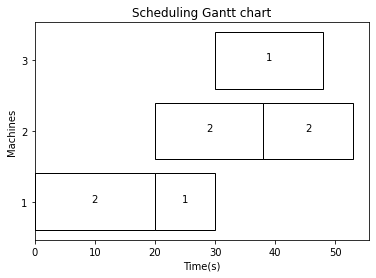

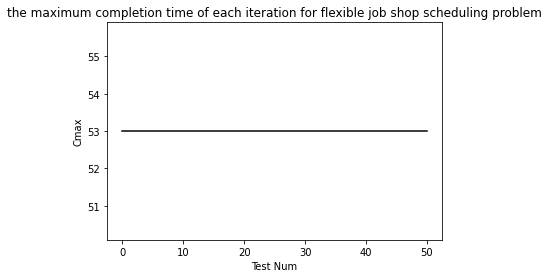

Solution found by genetic algorithm for Medium environment
best_fitness 55


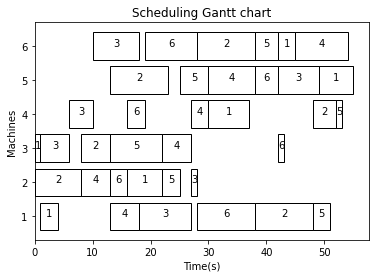

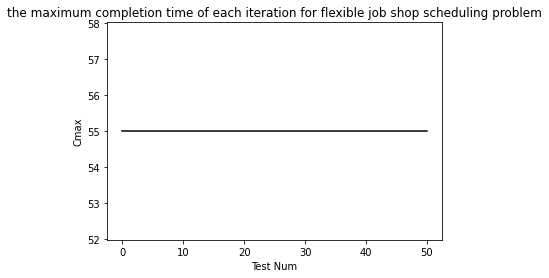

Solution found by genetic algorithm for Large environment
best_fitness 48


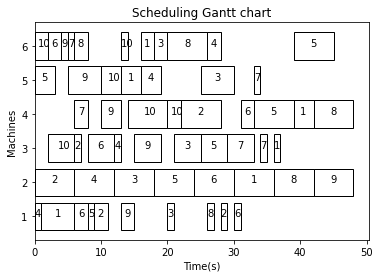

best_fitness 47


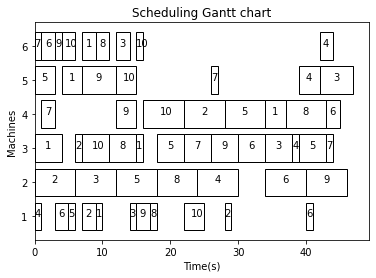

best_fitness 44


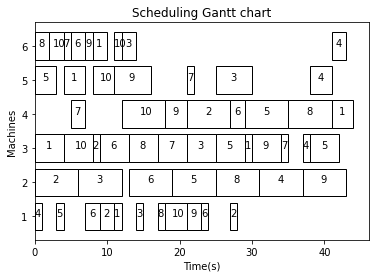

best_fitness 43


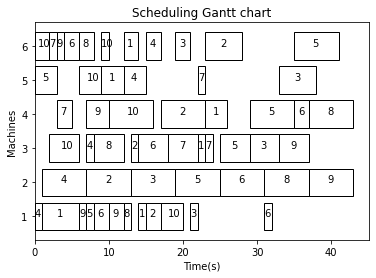

best_fitness 42


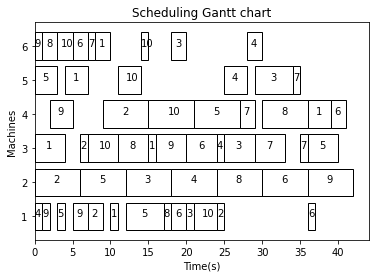

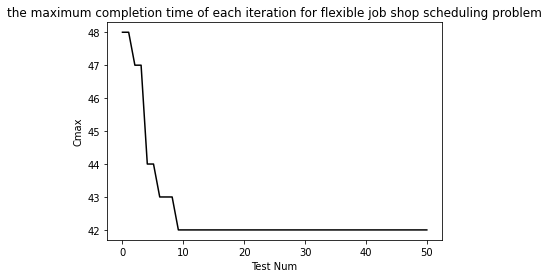

Solution found by genetic algorithm for Extra Large environment
best_fitness 1094


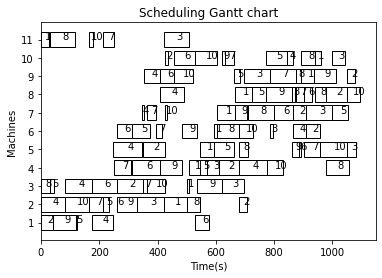

best_fitness 1078


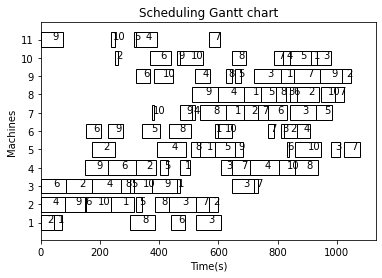

best_fitness 1074


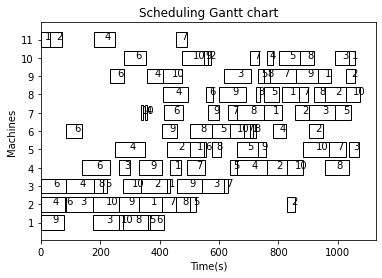

best_fitness 1062


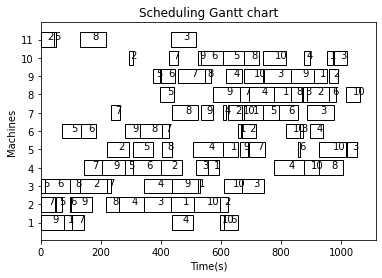

best_fitness 1045


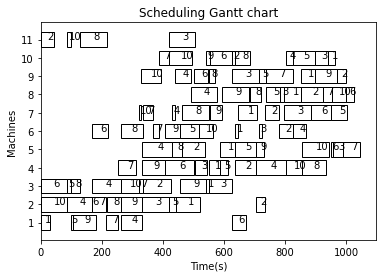

best_fitness 1020


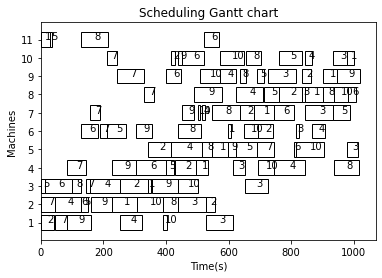

best_fitness 1004


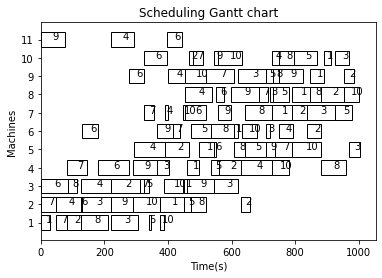

In [ ]:
solutions_rs = [0]*4
for i in range(4):
    print('Solution found by genetic algorithm for {} environment'.format(env_names[i]))
    Processing_time, J, M_num, J_num, O_num = initialize(env_list[i])
    g=GA()
    solutions_rs[i] = g.main(Processing_time,J,M_num,J_num,O_num)